# Power traces analysis

This is just a test before applying on the chips. It uses python rather than C.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pickle

Using TensorFlow backend.


In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000

## 1. Data Preprocessing

**Read data from csv file**: get data.

In [3]:
file_path = "../dataset/grafana_data_export.csv"

data = pd.read_csv(file_path, \
                   error_bad_lines=False, warn_bad_lines=False, \
                   sep=';', thousands=',', \
                   dtype={'Series': 'object', 'Value': 'float'}, \
                   parse_dates=['Time'])

display(data.head())
print("Data shape: {0}".format(data.shape))

,Series,Time,Value
0,Black and white printer,2018-10-27 16:44:25,3.31
1,Black and white printer,2018-10-27 16:44:25,3.31
2,Black and white printer,2018-10-27 16:44:26,4.29
3,Black and white printer,2018-10-27 16:44:26,4.29
4,Black and white printer,2018-10-27 16:44:27,3.77


Data shape: (1940080, 3)


In [4]:
data.dtypes

Series            object
Time      datetime64[ns]
Value            float64
dtype: object

**Label Encoding**

In [5]:
encoder = LabelEncoder()
data['Series'] = encoder.fit_transform(data['Series'])

display(data.head(10))

,Series,Time,Value
0,0,2018-10-27 16:44:25,3.31
1,0,2018-10-27 16:44:25,3.31
2,0,2018-10-27 16:44:26,4.29
3,0,2018-10-27 16:44:26,4.29
4,0,2018-10-27 16:44:27,3.77
5,0,2018-10-27 16:44:27,3.77
6,0,2018-10-27 16:44:28,4.03
7,0,2018-10-27 16:44:28,4.03
8,0,2018-10-27 16:44:30,2.71
9,0,2018-10-27 16:44:30,2.71


**Data Visualization**

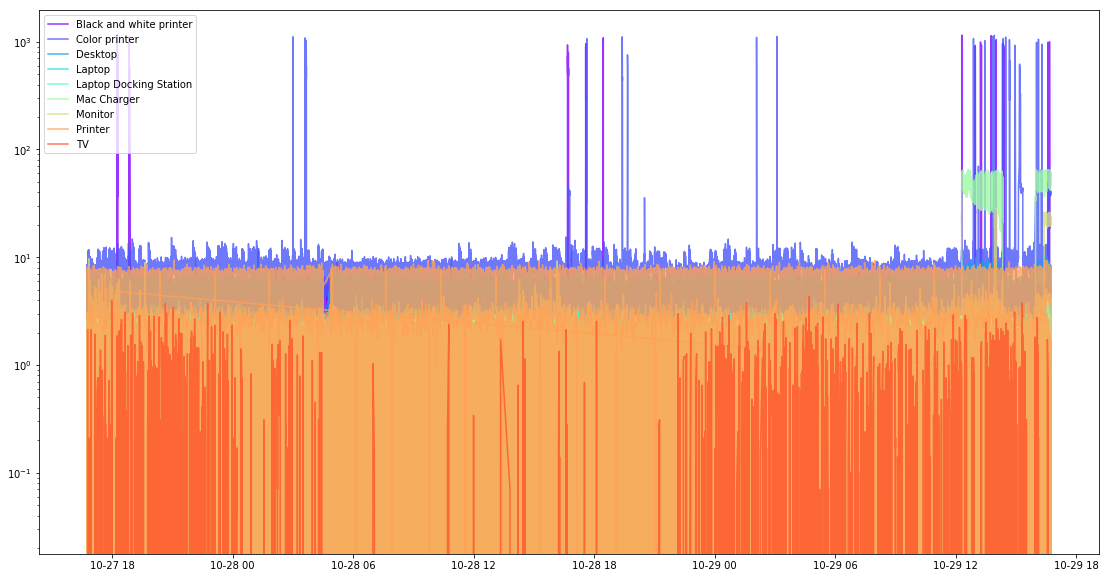

In [6]:
color = iter(plt.cm.rainbow(np.linspace(0,1,10)))

plt.figure(figsize=(19,10))

for cur_class in range(len(encoder.classes_)):
    c = next(color)
    indices = np.where(data['Series'] == cur_class)
    time = np.array(data.loc[indices[0], ['Time']])
    value = np.array(data.loc[indices[0], ['Value']])
    
    plt.plot(time, value, c=c, label=encoder.classes_[cur_class], alpha=0.8)

plt.yscale('log')
plt.legend()
plt.show()

**Filter and Resample**: Filter data with repeated time steps and NaN.

In [7]:
filtered_data = []

print("Size of samples from different classes:\n")
for cur_class in range(len(encoder.classes_)):
    indices = np.where(data['Series'] == cur_class)
    filtered_data.append(data.loc[indices[0], ['Time', 'Value']])
    
    print(" {0}: {1}".format(encoder.classes_[cur_class], filtered_data[cur_class].shape))

Size of samples from different classes:

 Black and white printer: (211917, 2)
 Color printer: (67373, 2)
 Desktop: (162914, 2)
 Laptop: (169641, 2)
 Laptop Docking Station: (207065, 2)
 Mac Charger: (162684, 2)
 Monitor: (544604, 2)
 Printer: (411291, 2)
 TV: (2591, 2)


In [8]:
for cur_class in range(len(encoder.classes_)):
    filtered_data[cur_class] = filtered_data[cur_class].resample('1S', on='Time').mean()
    filtered_data[cur_class].fillna(0, inplace=True)

**Partitioning**: partition the whole power traces into small traces with a duration of *k* seconds. The label of these small traces is the corresponding value in Series.

In [54]:
X, y = [], []

for cur_class in range(len(encoder.classes_)):
    print("Partitioning class {0}...".format(cur_class))
    
    value = np.array(filtered_data[cur_class]['Value'])
    series = np.array(np.full(value.shape, cur_class))
    
    generator = TimeseriesGenerator(value, series,
                       length=60, sampling_rate=1, batch_size=1)
    
    for sample in generator:
        X.append(sample[0])
        y.append(cur_class)

X, y = np.array(X), np.array(y)

Partitioning class 0...
Partitioning class 1...
Partitioning class 2...
Partitioning class 3...
Partitioning class 4...
Partitioning class 5...
Partitioning class 6...
Partitioning class 7...
Partitioning class 8...


In [55]:
X = np.reshape(X, (X.shape[0], X.shape[2]))

(**\*Save data in file / Load data from file**: Reduce unnecessary computation.)

In [56]:
dataFile = "X_y_data"

In [57]:
with open(dataFile, 'wb') as outfile:
    pickle.dump([X, y], outfile)

In [58]:
with open(dataFile, 'rb') as infile:
    X, y = pickle.load(infile)

**FFT**

In [59]:
fft_X_real, fft_X_imag = np.empty(X.shape), np.empty(X.shape)
 
for i in range(len(X)):
    sp = np.fft.fft(X[i, :])
    fft_X_real[i, :] = sp.real
    fft_X_imag[i, :] = sp.imag

**Generating training/testing data set**: train test split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=76)
print("{0} train + {1} validation + {2} test".format(len(X_train), len(X_val), len(X_test)))

994633 train + 248659 validation + 310823 test


**Data Visualization**: Visualize different types of signals.

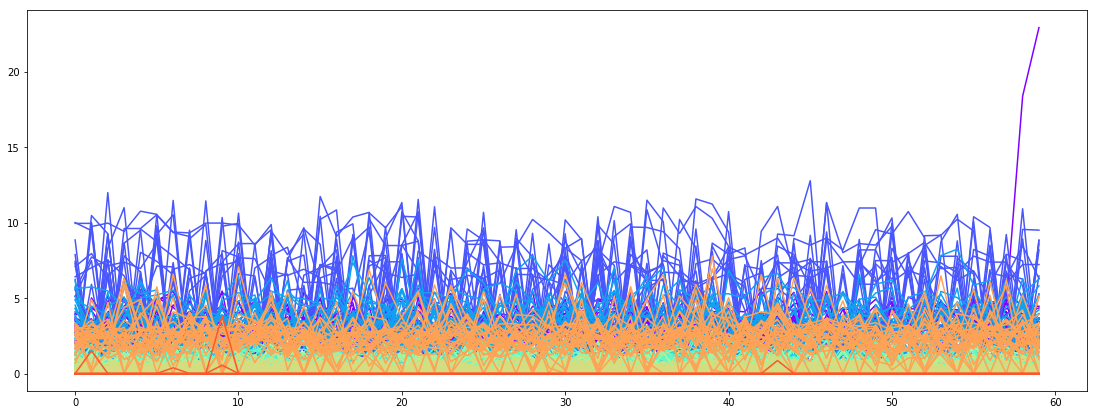

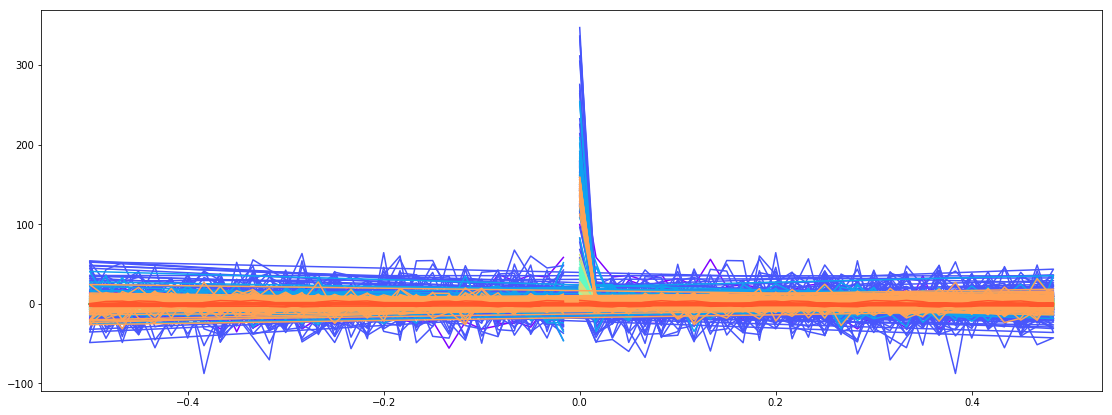

In [61]:
color = iter(plt.cm.rainbow(np.linspace(0,1,10)))

fig1, ax1 = plt.subplots(figsize=(19, 7))
fig2, ax2 = plt.subplots(figsize=(19,7))

t = np.arange(60)
freq = np.fft.fftfreq(t.shape[-1])
for k in range(9):
    c = next(color)
    for sample in X_train[np.where(y_train == k)[0][:30]]:
        ax1.plot(np.arange(0, 60, 1), sample, c=c)
        
        sp = np.fft.fft(sample)
        freq = np.fft.fftfreq(t.shape[-1])
        ax2.plot(freq, sp.real, freq, sp.imag, c=c)

plt.show()

## 2. Try different classification models

Followed the document [Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) and [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) on scikit learn site.

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [18]:
names = ["Linear SVM", 
         "RBF SVM",
         "Random Forest", 
         "Neural Net",
         "Voting"]

classifiers = [
    SVC(kernel='linear', C=0.1),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=2, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    VotingClassifier(estimators=[
        ('knn', KNeighborsClassifier(3)), 
        ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)), 
        ('nn', MLPClassifier(alpha=1))], voting='hard')
]

In [19]:
train_size = 10000
test_size = 1000

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear SVM:
accuracy score: 0.458
Confusion matrix, without normalization
[[ 26   4  24   0   0   7   0  34   1]
 [ 30  17  14   6   7  18   4  17   1]
 [ 38   5  33   0   1  20   0  23   1]
 [  0   0   0  58   0  16  21   0   3]
 [  0   0   0   0 102  18   4   0   0]
 [  0   0   9  74   0   7  14   0   1]
 [  0   0   0  33   4  11  70   0   0]
 [ 38   2  18   0   0  20   0  42   0]
 [  0   0   0   1   0   0   0   0 103]]


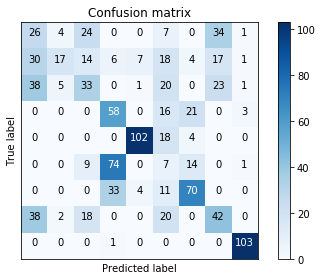

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RBF SVM:
accuracy score: 0.222
Confusion matrix, without normalization
[[  0   0   0   0  95   0   0   0   1]
 [  0   1   0   0 112   0   0   0   1]
 [  0   0   0   0 120   0   0   0   1]
 [  0   0   0   0  95   0   0   0   3]
 [  0   0   0   0 124   0   0   0   0]
 [  0   0   0   0 105   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0]
 [  0   0   0   3   4   0   0   0  97]]


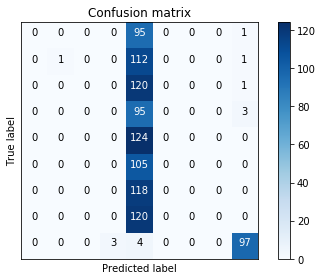

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest:
accuracy score: 0.409
Confusion matrix, without normalization
[[  8   0   0   0   0   0   3  84   1]
 [  4  49   1   1   3   0   3   3  50]
 [  8   0   0   0   1   0   1 109   2]
 [  0   0   0   2   1   0  25   0  70]
 [  4   0   0   1  12   0 100   4   3]
 [  1  10   0   0   2   0  24   0  68]
 [  0   0   0   0   0   0 116   0   2]
 [  2   0   0   0   0   0   0 118   0]
 [  0   0   0   0   0   0   0   0 104]]


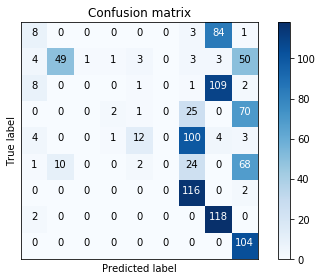

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural Net:
accuracy score: 0.706
Confusion matrix, without normalization
[[ 48   2  33   0   0   0   0  12   1]
 [ 12  94   1   5   1   0   0   0   1]
 [ 44   1  56   0   1   0   0  18   1]
 [  0   0   0  60   2  22  11   0   3]
 [  0   0   0   0 122   0   2   0   0]
 [  0   3   0  61   0  30   9   0   2]
 [  0   0   0   1   4   3 110   0   0]
 [ 14   0  24   0   0   0   0  82   0]
 [  0   0   0   0   0   0   0   0 104]]


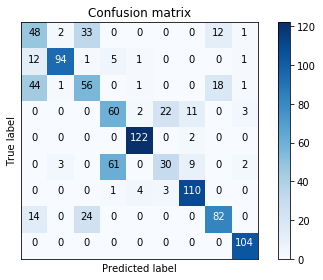

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Voting:
accuracy score: 0.656
Confusion matrix, without normalization
[[ 61   2  10   0   0   0   0  22   1]
 [ 12  95   1   2   2   0   0   0   2]
 [ 58   0  13   0   1   0   0  48   1]
 [  0   0   0  74   0   8  11   0   5]
 [  0   0   0   4  74   0  46   0   0]
 [  0   1   0  75   1  14  10   0   4]
 [  0   0   0   1   0   0 117   0   0]
 [ 13   0   3   0   0   0   0 104   0]
 [  0   0   0   0   0   0   0   0 104]]


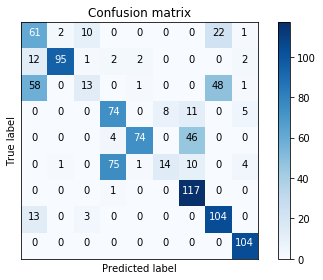

In [20]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train[:train_size, :], y_train[:train_size])
    y_pred = clf.predict(X_test[:test_size, :])
    
    score = accuracy_score(y_test[:test_size], y_pred)
    
    print("{0}:".format(name))
    print("accuracy score: {0}".format(score))
    
    cnf_matrix = confusion_matrix(y_test[:test_size], y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[])
    plt.show()

## 3. Using Neural Network

In [62]:
import keras
from keras.models import Sequential
from keras.models import Input, Model
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, GRU
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from tcn import TCN

**Get new nn_y_train and nn_y_test**: To meet the output layer requirement of DNN.

In [65]:
hot_encoder = OneHotEncoder(categories='auto')

hot_encoder.fit(y_train.reshape(-1, 1))
y_train = hot_encoder.transform(y_train.reshape(-1, 1)).toarray()
y_test = hot_encoder.transform(y_test.reshape(-1, 1)).toarray()

**Training and Testing**

In [66]:
train_size = 1400000
val_size = 10000
test_size = 100000

X_train = np.reshape(X_train, (X_train.shape[0],
                              X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],
                              X_test.shape[1]))

**DNN**

In [67]:
model = Sequential()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.add(Dense(128, activation='relu', input_dim=60))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

adam = Adam()
model.compile(loss='mse',
              optimizer=adam,
              metrics=['accuracy'])

history = model.fit(X_train[:train_size], y_train[:train_size], 
                    epochs=50, batch_size=200, validation_split=0.2,
                    callbacks=[early_stopping])

Train on 795706 samples, validate on 198927 samples
Epoch 1/50
795706/795706 [==============================] - 10s 12us/step - loss: 0.0434 - acc: 0.7026 - val_loss: 0.0347 - val_acc: 0.7631
Epoch 2/50
795706/795706 [==============================] - 9s 11us/step - loss: 0.0333 - acc: 0.7693 - val_loss: 0.0321 - val_acc: 0.7785
Epoch 3/50
795706/795706 [==============================] - 8s 10us/step - loss: 0.0317 - acc: 0.7812 - val_loss: 0.0312 - val_acc: 0.7825
Epoch 4/50
795706/795706 [==============================] - 8s 11us/step - loss: 0.0308 - acc: 0.7874 - val_loss: 0.0302 - val_acc: 0.7923
Epoch 5/50
795706/795706 [==============================] - 8s 10us/step - loss: 0.0300 - acc: 0.7941 - val_loss: 0.0298 - val_acc: 0.7968
Epoch 6/50
795706/795706 [==============================] - 9s 11us/step - loss: 0.0294 - acc: 0.7995 - val_loss: 0.0292 - val_acc: 0.8017
Epoch 7/50
795706/795706 [==============================] - 9s 11us/step - loss: 0.0288 - acc: 0.8051 - val_loss:

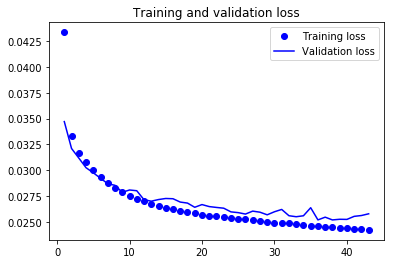

Confusion matrix, without normalization
[[10164   133   935     1     0     0     0    31    10]
 [   12 10793    22     0     0     0     0     0   154]
 [ 3822    35  6565     0     0     0     0   694    90]
 [    0     0     0  6476    15  4207     1     0   477]
 [    0     0     0    12 10982    64    61     1     6]
 [    0   662     1  3658    12  6676     7     0   126]
 [    0    49    53     2   101    56 10742     0     6]
 [  383     0   949    43     4    26     0  9745     8]
 [    0     5     0    15     0     4     0     0 10904]]


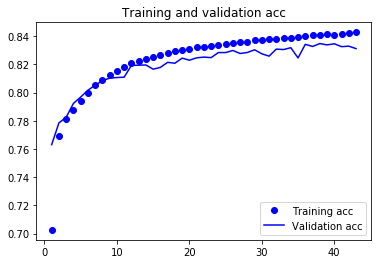

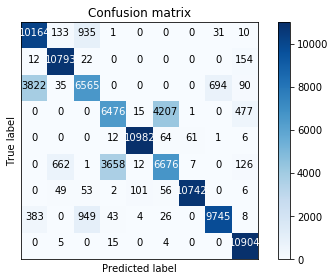

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

y_pred = model.predict_classes(X_test[:test_size])
cnf_matrix = confusion_matrix(hot_encoder.inverse_transform(y_test)[:test_size], y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[])

plt.show()

In [69]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
loss_and_metrics

310823/310823 [==============================] - 2s 6us/step


[0.025904669847234534, 0.8309488036609196]

**Extract DNN parameters**

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               7808      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 8,969
Trainable params: 8,969
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.save_weights("DNN_weights")

In [29]:
with open('DNN_weights.txt', 'w') as inFile:
    for layer in model.get_weights():
        inFile.write('(' + ','.join(map(str, layer.shape)) + ')\n')
        for i in layer:
            inFile.write(np.array2string(i, separator=',').replace('\n', '').replace(' ', ''))
            inFile.write('\n')

**RNN**

In [ ]:
batch_size, timesteps, input_dim = None, 30, 1

i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        use_skip_connections=True,
        nb_stacks=2,
        dilations=[2 ** i for i in range(9)])(i)  # The TCN layers are here.
o = Dense(100, activation='relu')(o)
o = Dense(9, activation='softmax')(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = m.fit(X_train[:train_size], nn_y_train[:train_size], epochs=10, validation_split=0.2)

In [ ]:
score = m.evaluate(X_test[:test_size], nn_y_test[:test_size])
score

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
################## TEST SECTION ###################
cur_idx = 1000000

In [80]:
X[cur_idx]

array([0.   , 0.   , 0.   , 0.65 , 0.155, 0.   , 0.   , 0.41 , 0.   ,
       0.   , 1.275, 0.   , 0.   , 0.725, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.68 , 0.   , 2.41 , 0.   , 0.   , 0.   , 1.14 , 0.   ,
       0.055, 0.6  , 0.88 , 0.23 , 0.   , 0.925, 0.43 , 0.   , 0.77 ,
       0.   , 0.31 , 0.   , 0.45 , 0.   , 0.   , 0.455, 0.   , 0.14 ,
       0.   , 0.   , 0.   , 0.   , 0.34 , 0.   , 0.535, 0.14 , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.325, 0.   ])

In [81]:
y[cur_idx]

5

In [84]:
model.predict_classes(X_)

array([6, 6, 7, ..., 0, 8, 6], dtype=int64)

In [86]:
hot_encoder.inverse_transform(y_test)

array([[6],
       [6],
       [7],
       ...,
       [0],
       [8],
       [6]])